<a href="https://colab.research.google.com/github/shantanu-jain-35/coms-4995-medical-imaging/blob/master/coms_4995_project_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime
!apt-get install openslide-tools
!pip install openslide-python
%load_ext autotime

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7.11 s (started: 2021-04-25 04:44:45 +00:00)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from openslide import open_slide, __library_version__ as openslide_version
import seaborn as sns; sns.set_theme()
import numpy as np
import os
from PIL import Image

time: 7.72 ms (started: 2021-04-25 04:45:00 +00:00)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.__version__

'2.4.1'

time: 8.31 ms (started: 2021-04-25 04:45:05 +00:00)


In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
time: 6.17 ms (started: 2021-04-25 04:45:08 +00:00)


In [ ]:
ls /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/

cancerous/  normal/
time: 123 ms (started: 2021-04-25 04:45:12 +00:00)


### Creating a tf.Dataset object from the image 

In [ ]:
PATCH_SIZE = 100
LEVEL = 5
training_dir = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/"

time: 3.46 ms (started: 2021-04-25 04:45:20 +00:00)


shape:  (100, 100, 3)


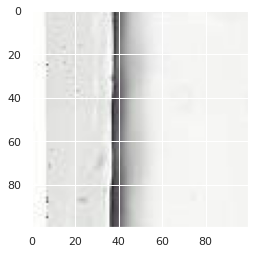

time: 841 ms (started: 2021-04-25 04:45:27 +00:00)


In [ ]:
# read some files and display the same
for file in os.listdir(training_dir+'normal'):
    image = mpimg.imread(os.path.join(training_dir, 'normal', file))
    print("shape: ", image.shape)
    plt.imshow(image)
    break
# os.listdir(training_dir+'normal')

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir,
    batch_size=1, 
    image_size=(PATCH_SIZE, PATCH_SIZE),
    validation_split=0.2,
    subset='training',
    seed=123
    )

Found 4411 files belonging to 2 classes.
Using 3529 files for training.
time: 247 ms (started: 2021-04-25 04:45:38 +00:00)


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir,
    batch_size=1, 
    image_size=(PATCH_SIZE, PATCH_SIZE),
    validation_split=0.2,
    subset='validation',
    seed=123
    )

Found 4411 files belonging to 2 classes.
Using 882 files for validation.
time: 234 ms (started: 2021-04-25 04:45:44 +00:00)


In [ ]:
# playing with the dataset
print("The classes are: ", train_ds.class_names)
class_names = train_ds.class_names

The classes are:  ['cancerous', 'normal']
time: 3.9 ms (started: 2021-04-25 04:45:47 +00:00)


### Displaying some of the patches

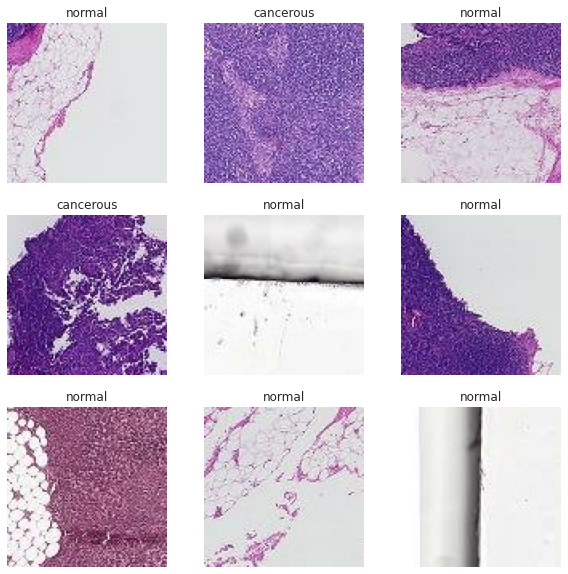

time: 9.22 s (started: 2021-04-25 04:45:50 +00:00)


In [ ]:
plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")
    i += 1

### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)

time: 11.2 ms (started: 2021-04-25 04:46:11 +00:00)


### Create the model

In [ ]:
num_classes = 1
model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  layers.Flatten(),
#   layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

time: 48.6 ms (started: 2021-04-25 04:46:23 +00:00)


In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

time: 14.2 ms (started: 2021-04-25 04:46:25 +00:00)


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 20001     
Total params: 25,089
Trainable params: 25,089
Non-trainable params: 0
__________________________________________________

In [ ]:
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3529/3529 [==============================] - 2087s 525ms/step - loss: 4.7780 - accuracy: 0.8396 - val_loss: 0.3342 - val_accuracy: 0.8673
Epoch 2/10
3529/3529 [==============================] - 33s 9ms/step - loss: 0.4494 - accuracy: 0.8577 - val_loss: 0.3563 - val_accuracy: 0.8549
Epoch 3/10
3529/3529 [==============================] - 33s 9ms/step - loss: 0.4801 - accuracy: 0.8530 - val_loss: 0.3822 - val_accuracy: 0.8696
Epoch 4/10
3529/3529 [==============================] - 33s 9ms/step - loss: 0.3852 - accuracy: 0.8619 - val_loss: 0.3304 - val_accuracy: 0.8628
Epoch 5/10
3529/3529 [==============================] - 33s 9ms/step - loss: 0.5198 - accuracy: 0.8601 - val_loss: 0.3347 - val_accuracy: 0.8685
Epoch 6/10
3529/3529 [==============================] - 33s 9ms/step - loss: 0.4112 - accuracy: 0.8530 - val_loss: 0.3433 - val_accuracy: 0.8685
Epoch 7/10
3529/3529 [==============================] - 33s 9ms/step - loss: 0.3669 - accuracy: 0.8539 - val_loss: 0.3367 - va

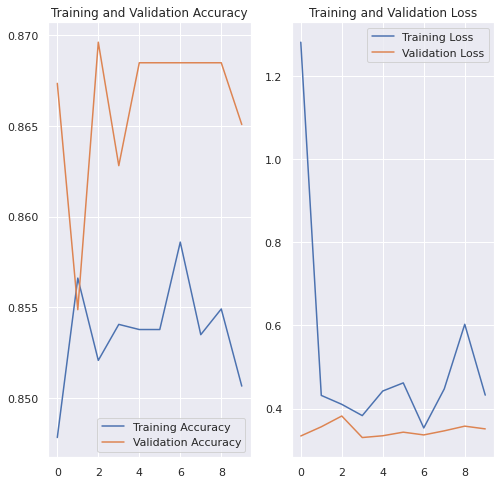

time: 442 ms (started: 2021-04-25 05:29:36 +00:00)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on the test data

In [ ]:
# test data path
test_tumor_path = '/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor'
test_tumor_mask_path = '/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor_mask'

time: 1.19 ms (started: 2021-04-25 05:30:17 +00:00)


In [ ]:
os.listdir(test_tumor_path)[0]

'tumor_023.tif'

time: 12.2 ms (started: 2021-04-25 05:30:18 +00:00)


In [ ]:
# adding the files in lists for maintaining consistency
tumors_tifs = []
tumors_mask_tifs = []
for filename in os.listdir(test_tumor_path):
    tumors_tifs.append(os.path.join(test_tumor_path, filename))
for filename in os.listdir(test_tumor_mask_path):
    tumors_mask_tifs.append(os.path.join(test_tumor_mask_path, filename))

tumors_tifs.sort()
tumors_mask_tifs.sort()
print("Length of tumor tiffs: {}".format(len(tumors_tifs)))
print("Length of tumor mask tiffs: {}".format(len(tumors_mask_tifs)))

Length of tumor tiffs: 2
Length of tumor mask tiffs: 2
time: 10.3 ms (started: 2021-04-25 05:30:21 +00:00)


In [ ]:
# read slide and return an image
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

time: 4.77 ms (started: 2021-04-25 05:30:23 +00:00)


In [ ]:
def get_patches(tumors, masks, patch_size=100, level=5):
    slides_patches = []
    cancerous_patches = []
    for tumor, mask in zip(tumors, masks):
        # get wsi for the tiffs
        tumor_image = open_slide(tumor)
        mask_image = open_slide(mask)

        # strides for the patch
        stride_width = tumor_image.level_dimensions[level][0] // patch_size
        stride_height = tumor_image.level_dimensions[level][1] // patch_size

        # downsampling factor
        downsample_factor = tumor_image.level_downsamples[level]

        print("For tumor: {}".format(tumor))
        print("width, height, downsample: {}, {}, {}".format(stride_width, stride_height, downsample_factor))

        for width in range(stride_width):
            for height in range(stride_height):
                top_x = int(patch_size * width * downsample_factor)
                top_y = int(patch_size * height * downsample_factor)

                # slide patch
                slide_patch = read_slide(tumor_image, top_x, top_y, level, width=patch_size, height=patch_size)
                # mask patch
                mask_patch = read_slide(mask_image, top_x, top_y, level, width=patch_size, height=patch_size)

                # if check_tissue_percentage_threshold(slide_patch) == False:
                #     continue

                slides_patches.append(slide_patch)

                if np.sum(mask_patch[:, :, 0] > 0):
                    cancerous_patches.append(1)
                else:
                    cancerous_patches.append(0)
    return slides_patches, cancerous_patches


time: 24.2 ms (started: 2021-04-25 05:30:26 +00:00)


In [ ]:
slides_patches, cancerous_patches = get_patches([tumors_tifs[0]], [tumors_mask_tifs[0]], level=LEVEL, patch_size=PATCH_SIZE)

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_023.tif
width, height, downsample: 30, 69, 32.0
time: 2.4 s (started: 2021-04-25 05:30:29 +00:00)


In [ ]:
print("Number of slides: {}".format(len(slides_patches)))
print("Number of cancerous: {}".format(np.sum(cancerous_patches)))
print(cancerous_patches)

Number of slides: 2070
Number of cancerous: 5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
test_image = slides_patches[0]
test_image = tf.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)
prediction

array([[0.93407]], dtype=float32)

time: 81.3 ms (started: 2021-04-25 05:30:38 +00:00)


In [ ]:
predictions = []
for patch in slides_patches:
    image = tf.expand_dims(patch, axis=0)
    prediction = model.predict(image)[0][0]
    predictions.append(prediction)


predictions = np.array(predictions)
thresholded_predictions = np.zeros(len(predictions))
# plt.imshow(np.resize(predictions, (10, 12)))

for index in range(len(predictions)):
    if predictions[index] < 0.5:
        thresholded_predictions[index] = 1

print("Threshold Predictions: ", thresholded_predictions) 
# print(test_acc(cancerous_patches, predictions))

Threshold Predictions:  [0. 0. 0. ... 0. 0. 0.]
time: 1min 18s (started: 2021-04-25 05:30:44 +00:00)


In [ ]:
test_acc = tf.keras.metrics.binary_accuracy(cancerous_patches, thresholded_predictions)
print("Accuracy: ", test_acc)

Accuracy:  tf.Tensor(0.99661833, shape=(), dtype=float32)
time: 5.34 ms (started: 2021-04-25 05:32:11 +00:00)


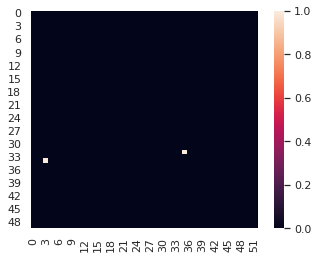

time: 620 ms (started: 2021-04-25 05:33:11 +00:00)


In [ ]:
test_image = open_slide(tumors_tifs[0])
# predicted_mask_image = Image.fromarray(np.resize(thresholded_predictions, (90, 90)))

# plt.imshow(predictions.resize((image.level_dimensions[LEVEL][0], image.level_dimensions[LEVEL][1])))
# plt.imshow(image)
plt.imshow(predicted_mask_image, cmap='jet')
# sns.heatmap(np.resize(predictions, (10, 12)))
sns.heatmap(np.resize(thresholded_predictions, (50, 52)))

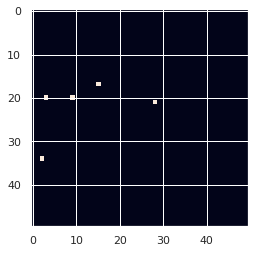

time: 275 ms (started: 2021-04-25 05:32:33 +00:00)


In [ ]:
plt.imshow(np.resize(cancerous_patches, (50, 50)))